Steps for NLP Model Build:

# Problem Statement
## Do the Questions Asked by Customers in the Amazon Food Category Get Answered Correctly
A Capstone project applying NLP modeling to Amazon Question and Answer banks 

by Robert Spoonmore

# Data Source:
https://jmcauley.ucsd.edu/data/amazon/qa/qa_Grocery_and_Gourmet_Food.json.gz

***Citation:***

Modeling ambiguity, subjectivity, and diverging viewpoints in opinion question answering systems
Mengting Wan, Julian McAuley
International Conference on Data Mining (ICDM), 2016

Addressing complex and subjective product-related queries with customer reviews
Julian McAuley, Alex Yang
World Wide Web (WWW), 2016

# Data Import Instructions:

***Reading the data***
Data can be treated as python dictionary objects. A simple script to read any of the above the data is as follows:

def parse(path): g = gzip.open(path, 'r') for l in g: yield eval(l)


***Convert to 'strict' json***
The above data can be read with python 'eval', but is not strict json. If you'd like to use some language other than python, you can convert the data to strict json as follows:

import json import gzip def parse(path): g = gzip.open(path, 'r') for l in g: yield json.dumps(eval(l)) f = open("output.strict", 'w') for l in parse("qa_Video_Games.json.gz"): f.write(l + '\n')


***Pandas data frame***
This code reads the data into a pandas data frame:

import pandas as pd import gzip def parse(path): g = gzip.open(path, 'rb') for l in g: yield eval(l) def getDF(path): i = 0 df = {} for d in parse(path): df[i] = d i += 1 return pd.DataFrame.from_dict(df, orient='index') df = getDF('qa_Video_Games.json.gz')

In [1]:
# NOTE: RUN THIS IN ANACONDA ENVIROMENT WINDOW BEFORE RUNNING NOTEBOOK
# This prevents the 'IOPub data rate exceeded' error

# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [2]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import json
import numpy as np
import pandas as pd
import gzip
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim.models import doc2vec, Word2Vec, KeyedVectors  # Updated to 4.0 for Gensim - some changes since 3.x
from gensim.models.doc2vec import TaggedDocument
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy.spatial import distance
from gensim.models.phrases import Phrases, Phraser  # for bigram creation
from gensim import corpora
from gensim.corpora.dictionary import Dictionary    # for dictionary of corpus creation
from pprint import pprint
import transformers as ppb        # BERT model

# Import data

In [3]:
# Define path for Amazon data
path = r'/Users/robertspoonmore/Desktop/Capstone datasets/qa_Grocery_and_Gourmet_Food.json.gz'

***Data Structure***

asin - ID of the product

questionType - type of question. Could be 'yes/no' or 'open-ended'

answerType - type of answer. Could be 'Y', 'N', or '?' (if the polarity of the answer could not be predicted). 

Only present for yes/no questions.

answerTime - raw answer timestamp

unixTime - answer timestamp converted to unix time

question - question text

answer - answer text

In [4]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
        
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 

food_df = getDF(path)

In [5]:
print("shape: ",food_df.shape,"\n")
print("columns: ",food_df.columns,"\n")
print("DF info: ",food_df.info(),"\n")
food_df.head()

shape:  (19538, 7) 

columns:  Index(['questionType', 'asin', 'answerTime', 'unixTime', 'question', 'answer',
       'answerType'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19538 entries, 0 to 19537
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   questionType  19538 non-null  object 
 1   asin          19538 non-null  object 
 2   answerTime    19538 non-null  object 
 3   unixTime      18930 non-null  float64
 4   question      19538 non-null  object 
 5   answer        19538 non-null  object 
 6   answerType    7294 non-null   object 
dtypes: float64(1), object(6)
memory usage: 1.2+ MB
DF info:  None 



,questionType,asin,answerTime,unixTime,question,answer,answerType
0,open-ended,9742356831,"Mar 26, 2014",1.395817e+09,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,NaN
1,yes/no,9742356831,"Apr 2, 2014",1.396422e+09,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,N
2,open-ended,9742356831,"Apr 5, 2015",1.428217e+09,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,NaN
3,open-ended,9742356831,"Aug 19, 2014",1.408432e+09,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,NaN
4,open-ended,9742356831,"Aug 2, 2014",1.406963e+09,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,NaN


In [6]:
# Create food dataframe holding the product id, question, and associated answer
food = food_df[['asin', 'question', 'answer']]
food.head()

,asin,question,answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.


# Exploratory Data Analysis

In [7]:
# in viewing the df, look for missing values
print('shape: ',food.shape)
food.isna().sum()

shape:  (19538, 3)


asin        0
question    0
answer      0
dtype: int64

In [8]:
food.dtypes

asin        object
question    object
answer      object
dtype: object

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


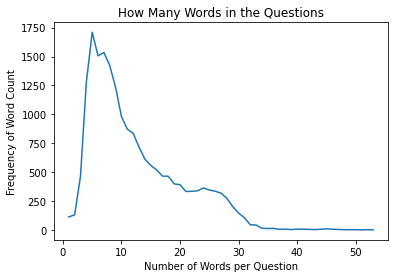

In [9]:
# Look at the word count of all the questions
food['words in question'] = food['question'].str.split().str.len()
word_count = food['words in question'].value_counts().sort_index(ascending=True)
labels = np.arange(1,len(word_count)+1,1)
plt.plot(labels,word_count)
plt.xlabel('Number of Words per Question')
plt.ylabel('Frequency of Word Count')
plt.title('How Many Words in the Questions')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


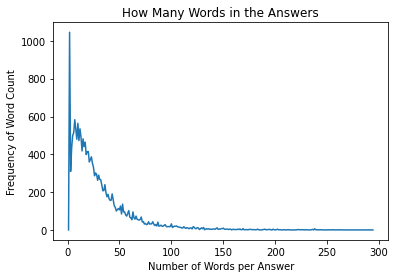

In [10]:
# Look at the word count of all the anwers
food['words in answer'] = food['answer'].str.split().str.len()
word_count = food['words in answer'].value_counts().sort_index(ascending=True)
labels = np.arange(1,len(word_count)+1,1)
plt.plot(labels,word_count)
plt.xlabel('Number of Words per Answer')
plt.ylabel('Frequency of Word Count')
plt.title('How Many Words in the Answers')
plt.show()

In [11]:
# Look at the type of answers we see in the category
food['words in answer'].value_counts()

1      1045
6       583
9       564
11      535
7       529
       ... 
248       1
232       1
200       1
615       1
527       1
Name: words in answer, Length: 294, dtype: int64

In [12]:
# From first run, looking at bigrams, the phrase 'messin_sasquach' refers to a repeated question
# That question is "What's your favorite way of messin' with Sasquach?"
# This is determined to be an outlier and to be removed from the data
print("Count of questions before deltion: ",len(food))
food = food.loc[food["question"]!= "What's your favorite way of messin' with Sasquach?"]
print("Count of questions after deltion: ",len(food),"\n")

Count of questions before deltion:  19538
Count of questions after deltion:  19527 



In [13]:
# We can see that there are 1045 answers that are only one word
one_word_answers = food[food['words in answer']==1]

# Create a series of data from the answer column
one_word_answers = one_word_answers['answer'].squeeze()
# lower case all letters
one_word_answers = one_word_answers.str.lower()
# remove periods at end of the answers - some yes show up as yes.
one_word_answers = one_word_answers.str.rstrip('.!? \n\t')
print('Count of all one word answers: ',len(one_word_answers))
print('\nTop frequency one word answers: \n'
      ,one_word_answers.value_counts().head(10))
# we can see a large volumne of yes,no answers and simple responses
# Look at unique responses that are website addresses
#web_links = one_word_answers[one_word_answers.str.contains('www')]
print('\nAnswers that are links ("www"): ',len(one_word_answers[one_word_answers.str.contains('www')]))

Count of all one word answers:  1045

Top frequency one word answers: 
 yes           422
no            217
plastic        22
glass          11
one             9
                9
nope            7
absolutely      7
yep             6
powder          6
Name: answer, dtype: int64

Answers that are links ("www"):  15


In [14]:
# remove rows for questions that have only 1 or 2 words
print("Shape of data before 1or2 word question removal: ",food.shape)
food = food[food['words in question']>2]
print("shape of data after:",food.shape)
print("min words per question: ",food['words in question'].min())
food.head()

Shape of data before 1or2 word question removal:  (19527, 5)
shape of data after: (19282, 5)
min words per question:  3


,asin,question,answer,words in question,words in answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,13,23
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,5,7
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,9,7
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,10,22
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,20,8


In [15]:
# remove rows for answers that are only 1 or 2 words long 
print("Shape of data before 1 word answer removal: ",food.shape)
food = food[food['words in answer']>2]
print("shape of data after:",food.shape)
print("min words per answer: ",food['words in answer'].min())
food.head()

Shape of data before 1 word answer removal:  (19282, 5)
shape of data after: (17946, 5)
min words per answer:  3


,asin,question,answer,words in question,words in answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,13,23
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,5,7
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,9,7
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,10,22
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,20,8


In [16]:
# Confirm there are no missing values
food.isnull().sum()

asin                 0
question             0
answer               0
words in question    0
words in answer      0
dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


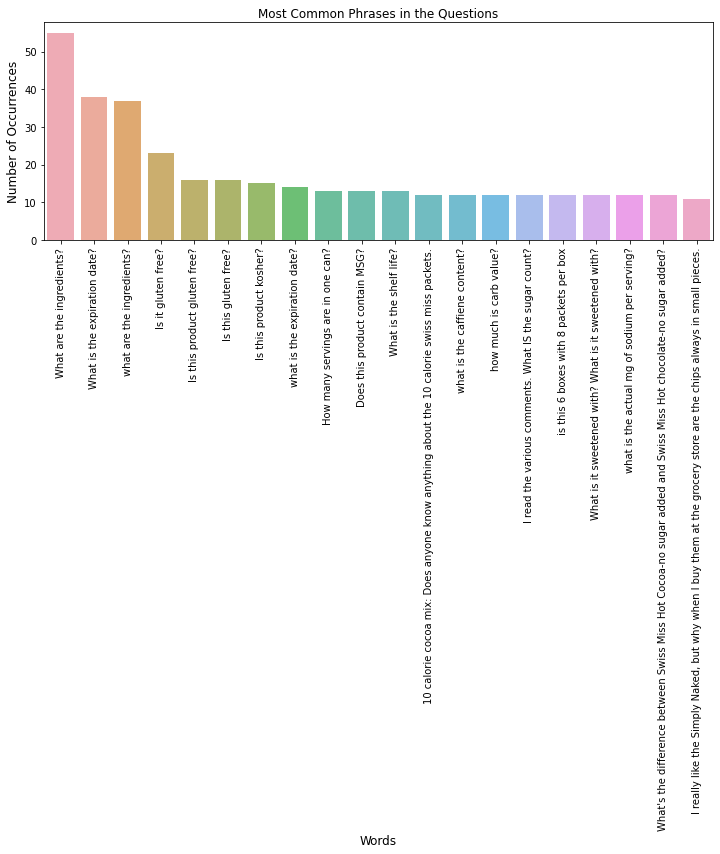

In [17]:
# Look at most common question phrases
cnt_q_words = food['question'].value_counts()[:20]
plt.figure(figsize=(12,4))
sns.barplot(cnt_q_words.index, cnt_q_words.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.xticks(rotation=90)
plt.title('Most Common Phrases in the Questions')
plt.show();

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


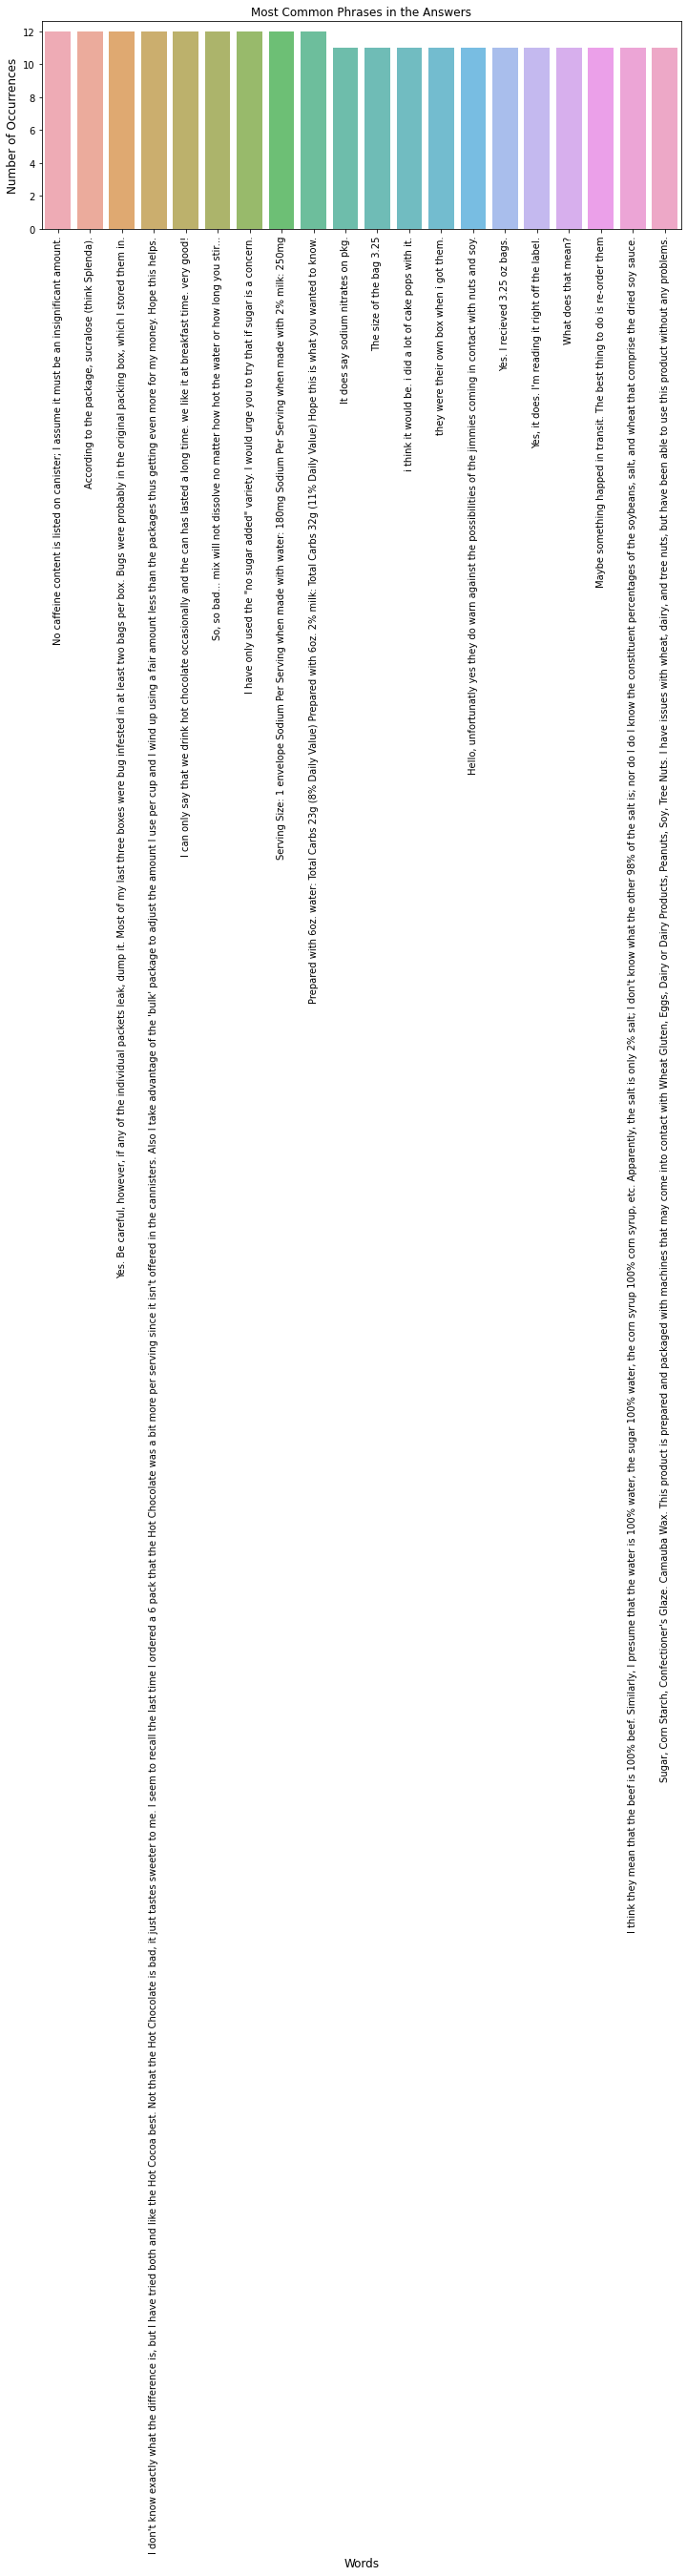

In [18]:
# Look at most common answer words
cnt_a_words = food['answer'].value_counts()[:20]
plt.figure(figsize=(12,4))
sns.barplot(cnt_a_words.index, cnt_a_words.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.xticks(rotation=90)
plt.title('Most Common Phrases in the Answers')
plt.show();

# Preparing the question text data

In [19]:
# Import necessary modules
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
# Only need to run the first time
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')

# Build a Dictionary of words for Questions and Answers 

A dictionary is a vectorized mapping of each word to a unique id location in the vector.  By creating a dictionary of all words in a document, a vector representing a location for each word is created.  The dictionary is then a map of the word locations

In [21]:
# Tokenize words within the phrase, not just a total bag of words
# method to tokenize anything sent to give back a list of list of words as they appeared
# strip out non-alphanumeric words (remove punctuation), remove stop words if requested
# return an overall list with phrase as separate list

def find_phrases(source, remove_stopwords=False):
    list_of_list_of_words = []
    for row in source:
        list_of_words = []
        tokens = word_tokenize(row)
        # Retain alphabetic words: alpha_only
        alpha_only = [t for t in tokens if t.isalpha()]
        # Lowercase
        lower_tokens = [t.lower() for t in alpha_only]
        # save resultant words
        if remove_stopwords:
            no_stops = [w for w in lower_tokens if w not in stopwords.words('english')]
            # save resultant words
            for word in no_stops:
                list_of_words.append(word)
        else:
            for word in lower_tokens:
                list_of_words.append(word)
        list_of_list_of_words.append(list_of_words)
        
    return list_of_list_of_words

In [22]:
# Find the most common words in the questions removing the stopwords 
question_words_all = find_phrases(food['question'], True)
q_dictionary = Dictionary(question_words_all)
print("Question Dictionary:\n",q_dictionary)


# Find the most common words in the answers removing the stopwords
answer_words_all = find_phrases(food['answer'], True)
a_dictionary = Dictionary(answer_words_all)
print("Answer Dictionary:\n",a_dictionary)

Question Dictionary:
 Dictionary(8998 unique tokens: ['compared', 'curry', 'heat', 'red', 'yellow']...)
Answer Dictionary:
 Dictionary(16351 unique tokens: ['deeper', 'flavor', 'green', 'mild', 'much']...)


In [23]:
# Combine for total dictionary
all_words = question_words_all + answer_words_all
all_dictionary = Dictionary(all_words)
print("Combined Dictionaries:\n",all_dictionary)

Combined Dictionaries:
 Dictionary(18505 unique tokens: ['compared', 'curry', 'heat', 'red', 'yellow']...)


In [24]:
# Create a bag of words for all questions and have a list of their frequencies
# Flatten the list of list of words
q_words_flat = [item for sublist in question_words_all for item in sublist]
# Create the list of words with frequency count
q_word_count = Counter(q_words_flat)
# Print top 25 words and their counts
print("Question words found: ",len(q_word_count))
top_q_words = q_word_count.most_common(30)

Question words found:  8998


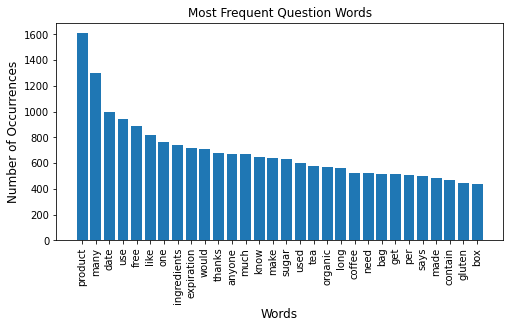

In [25]:
# Look at most common question words
plt.figure(figsize=(8,4))
plt.bar(range(len(top_q_words)), [val[1] for val in top_q_words], align='center')
plt.xticks(range(len(top_q_words)), [val[0] for val in top_q_words], rotation = 90)
plt.title("Most Frequent Question Words")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.show();

In [26]:
# Create a bag of words for all answers and have a list of their frequencies
# Flatten the list of list of words
a_words_flat = [item for sublist in answer_words_all for item in sublist]
# Create the list of words with frequency count
a_word_count = Counter(a_words_flat)
# Print top 25 words and their counts
print("Question words found: ",len(q_word_count))
top_a_words = a_word_count.most_common(30)

Question words found:  8998


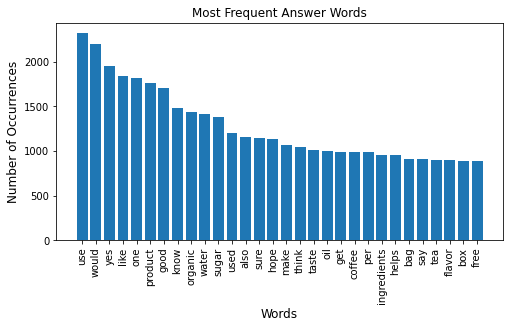

In [27]:
# Look at most common answer words
plt.figure(figsize=(8,4))
plt.bar(range(len(top_a_words)), [val[1] for val in top_a_words], align='center')
plt.xticks(range(len(top_a_words)), [val[0] for val in top_a_words], rotation = 90)
plt.title("Most Frequent Answer Words")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.show();

# Create Bag of Words Corpus for Questions and Answers

A Bag Of Words Corpus is a vector with the word id's and the count frequency of each word found in the document.

In [28]:
# Create corpus for questions
q_dict = Dictionary()
q_corpus = [q_dict.doc2bow(word, allow_update=True) for word in question_words_all]
print("question Corpus word count: ",len(q_corpus))

question Corpus word count:  17946


In [29]:
# Create corpus for answers
a_dict = Dictionary()
a_corpus = [a_dict.doc2bow(word, allow_update=True) for word in answer_words_all]
print("answer Corpus word count: ",len(a_corpus))

answer Corpus word count:  17946


In [30]:
# Create corpus for all words, combined questions and answers
all_dict = Dictionary()
all_corpus = [all_dict.doc2bow(word, allow_update=True) for word in all_words]
print("All words Corpus count: ",len(all_corpus))

All words Corpus count:  35892


# Extracting Key Words: Create TF-IDF matrix

The TF-IDF (Term Frequency - Inverse Document Frequency) takes the bag of words corpus and down weights the words that appear most frequently.  This normalizes the results to keep the high use words from dominating

Term Frequency:
Term frequency is defined as the number of times a word appears in a document divided by the total number of words in the document.


Inverse Document Frequency:
Inverse document frequency refers to the log of the total number of documents divided by the number of documents that contain the word. The logarithm is added to dampen the importance of a very high value of IDF.


TFIDF is computed by multiplying the term frequency with the inverse document frequency.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
# Method to find tf-idf terms scores and display top 10
# Pass in word list parameter
def tfidf_find_vals(words):
    tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
    tfidf_wm = tfidfvectorizer.fit_transform(words)
    tfidf_tokens = tfidfvectorizer.get_feature_names()
    df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)
    

    doc = 0
    feature_index = tfidf_wm[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_wm[doc, x] for x in feature_index])
    tfidf_scs = []
    print('Top feature Names:')
    for w, s in [(tfidf_tokens[i], s) for (i, s) in tfidf_scores]:
        print(w, s)

In [33]:
tfidf_find_vals(food['question'])

Top feature Names:
curry 0.5280719034995475
red 0.37460475940536125
yellow 0.4292527979030419
compared 0.4501747390819909
heat 0.4403363245862047


In [34]:
tfidf_find_vals(food['answer'])

Top feature Names:
red 0.24963019415811116
profile 0.40116616287683743
flavor 0.2004650839356598
deeper 0.42718542776135887
green 0.2503323670052263
mild 0.3294613696529366
yellow 0.5893069023938735
think 0.18863489360450084


# Create Bigrams finding combined terms

A bigram is a two word phrase that typically appears together to identify something unique.  
A trigram is a three word phrase.
Identifying the bigrams and trigrams makes the phrases appear as two_word and three_word_phrases 
in the corpus, thus combining the terms hand improving context identification

The questions and answers were sampled for trigrams, but not found to be significant
Only Bigrams will be applied

In [35]:
# Set up new DataFrame to save original questions and answers as well as those with bigrams
amazon = pd.DataFrame()
amazon[['asin','orig_question','orig_answer']] = food[['asin','question','answer']]
amazon.shape

(17946, 3)

In [36]:
# Find the Bigrams in the questions
q_bigram = Phrases(question_words_all, min_count=5, threshold=10)

q_bigram_list = []
for phrase, score in q_bigram.find_phrases(question_words_all).items():
    q_bigram_list.append([score,phrase])
q_bigram_list.sort(reverse=True)
print("Top 25 question bigrams found:\n")
pprint([x[1] for x in q_bigram_list][0:25])

Top 25 question bigrams found:

['hamilton_beach',
 'dolce_gusto',
 'trader_joe',
 'agave_nectar',
 'genetically_modified',
 'wan_na',
 'fair_trade',
 'trans_fats',
 'tender_bites',
 'cross_contamination',
 'swiss_miss',
 'monosodium_glutamate',
 'snap_carrot',
 'san_francisco',
 'stainless_steel',
 'madagascar_bourbon',
 'super_automatic',
 'citric_acid',
 'rim_cupcakes',
 'kick_ass',
 'gummy_bears',
 'length_width',
 'subscribe_save',
 'heavy_metals',
 'health_benefits']


In [37]:
# Find the Bigrams in the answers
a_bigram = Phrases(answer_words_all, min_count=5, threshold=10)
a_bigram_list = []
for phrase, score in a_bigram.find_phrases(answer_words_all).items():
    a_bigram_list.append([score,phrase])
a_bigram_list.sort(reverse=True)
print("Top 25 Answer bigrams found:\n")
pprint([x[1] for x in a_bigram_list][0:25])

Top 25 Answer bigrams found:

['chocolaty_rerfer',
 'possibilities_jimmies',
 'aspergillus_oryzae',
 'drift_pollinators',
 'sri_lanka',
 'dolce_gusto',
 'trading_gbi',
 'puerto_rico',
 'muir_glen',
 'bug_infested',
 'margaret_igourmet',
 'beta_carotene',
 'happed_transit',
 'flores_employee',
 'tim_hortons',
 'kicking_horse',
 'noe_rincon',
 'santa_trading',
 'dot_com',
 'monosodium_glutamate',
 'luo_han',
 'king_arthur',
 'jams_jellies',
 'hoosier_hill',
 'abuse_neglect']


In [38]:
# Find the Bigrams in all phrases
all_bigram = Phrases(all_words, min_count=5, threshold=10)
print("Top bigrams found in all phrases:\n")
all_bigram_list = []
for phrase, score in all_bigram.find_phrases(all_words).items():
    all_bigram_list.append([score,phrase])
all_bigram_list.sort(reverse=True)
pprint(all_bigram_list[0:20])

Top bigrams found in all phrases:

[[11677.58024691358, 'hong_kong'],
 [10509.822222222223, 'aspergillus_oryzae'],
 [9921.86013986014, 'drift_pollinators'],
 [9852.958333333332, 'puerto_rico'],
 [8758.185185185184, 'muir_glen'],
 [8445.392857142857, 'trading_gbi'],
 [8445.392857142857, 'luo_han'],
 [7711.010869565217, 'beta_carotene'],
 [7389.71875, 'sorbitan_monostearate'],
 [7006.548148148148, 'margaret_igourmet'],
 [6969.671578947368, 'flores_employee'],
 [6614.573426573426, 'dolce_gusto'],
 [6568.638888888889, 'noe_rincon'],
 [6568.638888888889, 'fog_chaser'],
 [6381.526236881559, 'sri_lanka'],
 [6334.044642857142, 'freedom_clip'],
 [6222.921052631578, 'kicking_horse'],
 [6063.358974358975, 'bug_infested'],
 [5971.489898989899, 'dot_com'],
 [5806.207589285714, 'monosodium_glutamate']]


In [39]:
# Find out which bigrams are common to both questions and answers
def common_bigram(lst1,lst2):
    same = []
    unique = []
    for s1,b1 in lst1:                        # score and bigram from 1st list
        if any(b2==b1 for (s2,b2) in lst2):  # score and bigram from 2nd list
            s2,b2 = [(s2,b2) for (s2,b2) in lst2 if b2==b1][0]
            same.append((b1,s1,s2))
        else: unique.append((b1,s1))
    print("Comparison Results: Bigrams Same ",len(same),"  Bigrams Different ",len(unique))
    return same, unique

Comparison Results: Bigrams Same  275   Bigrams Different  305
Similar Bigrams Count:  275


[]

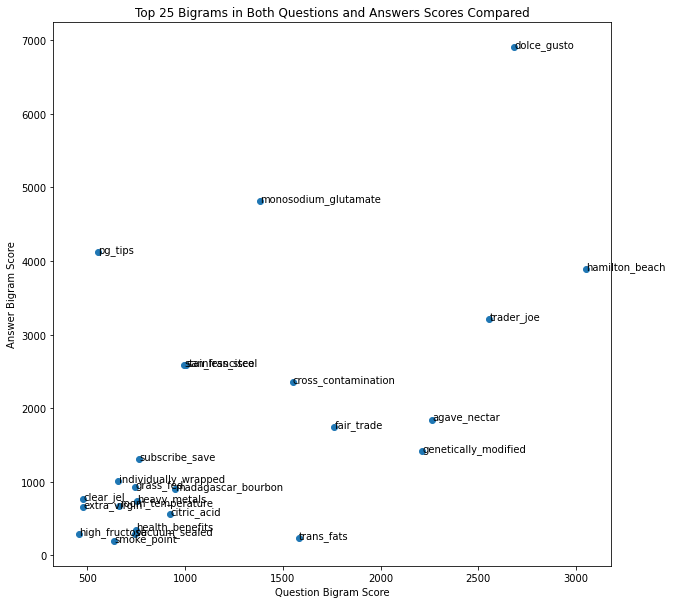

In [40]:
# Show the bigrams that are similar
similar, not_similar = common_bigram(q_bigram_list,a_bigram_list)
print("Similar Bigrams Count: ",len(similar))

# Plot scatter of words
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax.scatter([x[1] for x in similar][:25],[y[2] for y in similar][:25])
plt.xlabel("Question Bigram Score")
plt.ylabel("Answer Bigram Score")
plt.title("Top 25 Bigrams in Both Questions and Answers Scores Compared")
words = [z[0] for z in similar]
for i, word in enumerate(words[:25]):
   ax.annotate(word, xy=(similar[i][1]+2, similar[i][2]))
plt.plot()

In [41]:
# Save updated questions with bigrams
q_cleaned = all_bigram[question_words_all]
amazon['question'] = [q for q in q_cleaned]
amazon['question_str'] = [' '.join([str(item) for item in q]) for q in q_cleaned]
print(q_cleaned)

# Save updated answers with bigrams
a_cleaned = all_bigram[answer_words_all]
amazon['answer'] = [a for a in a_cleaned]
amazon['answer_str'] = [' '.join([str(item) for item in a]) for a in a_cleaned]
amazon.shape

(17946, 7)

In [42]:
# How many cleaned questions are only 1 word at this point?
one_word_questions = amazon[amazon['question'].str.len() <= 1]['question']
one_word_questions.value_counts()
one_word_questions.sort_values(ascending=False)
print("Number of one word questions: ",len(one_word_questions))
print("Most common one word questions",one_word_questions.value_counts())

Number of one word questions:  1822
Most common one word questions [expiration_date]    137
[ingredients]        114
[gluten_free]        107
[]                    58
[organic]             47
                    ... 
[pound]                1
[stir]                 1
[sweetner]             1
[usda_certified]       1
[delivered]            1
Name: question, Length: 495, dtype: int64


In [43]:
# How many cleaned answers are only 1 word at this point?
one_word_answers = amazon[amazon['answer'].str.len() <= 1]['answer']
one_word_answers.value_counts()
one_word_answers.sort_values(ascending=False)
print("Number of one word answers: ",len(one_word_answers))
print("Most common one word answers",one_word_answers.value_counts())

Number of one word answers:  670
Most common one word answers [yes]              85
[]                 59
[think]            19
[maybe_msg]        11
[sorry_know]       11
                   ..
[powdered_milk]     1
[salt]              1
[compatible]        1
[save]              1
[silly]             1
Name: answer, Length: 316, dtype: int64


In [44]:
# After stop word removal and bigram, still remove rows for questions and answers that are only 1 word long 
print("Shape of data before 1 word answer removal: ",amazon.shape)
amazon = amazon[amazon['question'].str.len() > 1]
amazon = amazon[amazon['answer'].str.len() > 1]
print("shape of data after:",amazon.shape)
print("min words per question: ",amazon['question'].str.len().min())
print("min words per answer: ",amazon['answer'].str.len().min())
food.head()

Shape of data before 1 word answer removal:  (17946, 7)
shape of data after: (15571, 7)
min words per question:  2
min words per answer:  2


,asin,question,answer,words in question,words in answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,13,23
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,5,7
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,9,7
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,10,22
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,20,8


In [45]:
# Combine questions and answers into a cleaned list of all terms
all_cleaned = all_bigram[all_words]

In [46]:
# Look at resultant dataframe
print('size of dataset: \n',amazon.shape)
amazon.head()

size of dataset: 
 (15571, 7)


,asin,orig_question,orig_answer,question,question_str,answer,answer_str
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,"[heat, compared, yellow_red, curry]",heat compared yellow_red curry,"[think, yellow, mild, green, much, deeper, fla...",think yellow mild green much deeper flavor pro...
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,"[ingredients, exactly, product, thanks]",ingredients exactly product thanks,"[ingredients_listed, description]",ingredients_listed description
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,"[important, expiraci, oacute, n, date, curry, ...",important expiraci oacute n date curry paste,"[never, pay_attention, ingredients, curry, pas...",never pay_attention ingredients curry paste lo...
5,9742356831,"Why is the photo of the product for Red Curry,...","I ordered one of each product, the red and the...","[photo, product, red, curry, selling, green_cu...",photo product red curry selling green_curry ge...,"[ordered, one, product, red, green, received, ...",ordered one product red green received one shi...
6,B00004S1C5,Why does this product come up first when doing...,Also. I am looking for organic coloring....not...,"[product, come, first, search, organic, food_c...",product come first search organic food_colorin...,"[also, looking, organic, coloring, red, dye, y...",also looking organic coloring red dye yes make...


# Create Topic Models with Hdp

Topic Modeling extracts the underlying topics giving the terms that have a relative combination of terms.  
The Hdp model is used when we have an unsupervised model - outputs not labeled
We must provide a best guess for the top number of topics, and the model shows the topic keywords found most

In [47]:
# Create method to provide the Topic Modeling
# Apply models from gensim for topic modeling applied only to the answers
# Use Hdp Model for unsupervised model - since we have no absolute confirmation on questions being answered
from gensim.models import HdpModel

def make_hdp(corp,dict,size):
    hdpm = HdpModel(corpus=corp,id2word=dict,random_state=23)
    # Capture word counts
    
    word_counts = [[(dict[id], count) for id, count in line] for line in corp]
    word_counts.sort(reverse=True)
    # Visualize top Hdp Predictions
    n_words = size
    topic_words = pd.DataFrame({})

    for i, topic in enumerate(hdpm.get_topics()[:n_words]):
        top_feature_ids = topic.argsort()[-10:][::-1]
        feature_values = topic[top_feature_ids]
        words = [dict[id] for id in top_feature_ids]
        topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
        topic_words = pd.concat([topic_words, topic_df], ignore_index=True)
    print("From HDP model, Topic Words include: \n",topic_words.head())

    # Graph the magnatude of the relative terms for each topic
    g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
    g.map(plt.barh, "word", "value")

From HDP model, Topic Words include: 
       value     word  topic
0  0.001718     foil      0
1  0.001244  product      0
2  0.001103      box      0
3  0.001092     come      0
4  0.001081    since      0


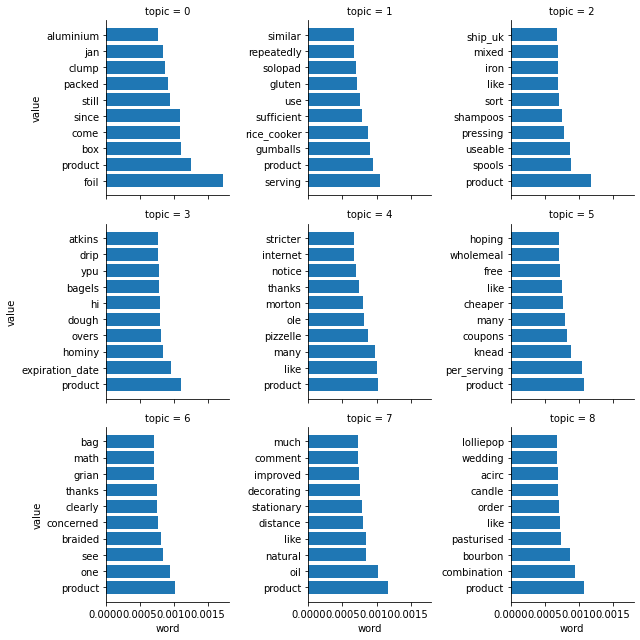

In [48]:
## update corpus from above with the found bigrams model
q_dict_cleaned = Dictionary(amazon['question'])
q_corpus_cleaned = [q_dict_cleaned.doc2bow(word, allow_update=True) for word in q_cleaned]

# Use make_hdp method to show topics for answers
make_hdp(q_corpus_cleaned,q_dict_cleaned,9)

# Topics identified through looking up the top words in the questions

There appears to be strong alginments for the top 9 topics:

1) **Product understanding:** Questions about contents, glutens, use, quantities, shelf life, expiration date

2) **Product match to equipment:** Questions related to machines requiring specific products

3) **product quality or clarity?:** Questions from customers to please be told about sourcing, organic nature and ingredients tied to organic nature

4) **Product shipment and conditions:** Questions about cost and type of shipping, what's included in box

5) **Customer complaints on product use:** Statements about issues with product and customer surpriseso

6) **Quantity and Sizing Understanding:** Customers want to know what is in the bag, how many, sizing

7) **Product sourcing conditions:** Customer asking to be told when and where was product made, contents, how prepared for shipment

8) **Customer quantity concerns:** How many in package, how many servings, how many units 

9) **Customer complaints on product use:** Customer concerns on quantities, certification clarity on honey, things to consider for better customer alignment, dislikes

From HDP model, Topic Words include: 
       value     word  topic
0  0.007628      use      0
1  0.006874  product      0
2  0.006100    would      0
3  0.005660      one      0
4  0.005565  organic      0


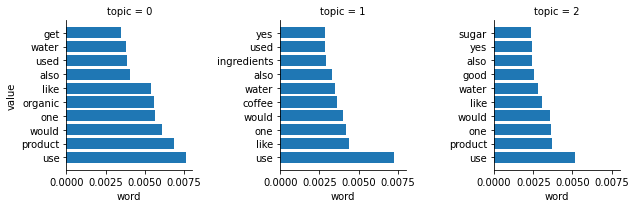

In [49]:
# Apply models from gensim for topic modeling applied only to the answers
## update corpus from above with the found bigrams model
a_dict_cleaned = Dictionary(amazon['answer'])
a_corpus_cleaned = [a_dict_cleaned.doc2bow(word, allow_update=True) for word in a_cleaned]

# Use make_hdp method to show topics for answers
make_hdp(a_corpus_cleaned,a_dict_cleaned,3)

# Topics identified through looking up the top words in the answers

The answer categories appear to offer only three strong topic

1) **Product use instructions:** Long worded explainations about how to use, many starting with "I have not..."

2) **Product Ingredients Detailed listing:** A restatement of contents in more detail, organic specifics

3) **Personal descriptions of product or competitor use:** Notes statements from box or manufacturer, how they substitute, or can something be substituted for it, a general statement about being 'good'


# Train Doc2Vec model with Gensim

The Doc2Vec model looks at all phrases and creates a vector based upon the frequency of words found 
based upon the bigram loaded corpus

In [50]:
# Train the Word2Vec model
def train_model(word_list):
   for i, list_of_words in enumerate(word_list):
      yield TaggedDocument(list_of_words, [i])
        
train_data = list(train_model(all_cleaned))

In [51]:
# Initialize the Model
d2v_model = doc2vec.Doc2Vec(vector_size=100, min_count=2, workers=3, seed=23, epochs=30)

# Build Vocabulary
d2v_model.build_vocab(train_data)

In [52]:
# Train Model and save results to be able to run model again
import time
start_time = time.time()
d2v_model.train(train_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
print("Time to train the model: ",round(time.time()-start_time),"seconds")
# Save model
d2v_model.save('d2v_food.model')

Time to train the model:  37 seconds


# Create Document Vectors

In [53]:
# Load Document To Vector model created in prior step based on the food data
d2v_model= doc2vec.Doc2Vec.load("d2v_food.model")

In [54]:
# Because we eliminated one word questions and answers, must update the question and answer list
# For document vectors to have correct indexing
question_words_all_reduced = []
[question_words_all_reduced.append(x) for x in amazon['question']]
print("Updated Question Length: ",len(question_words_all_reduced))

answer_words_all_reduced = []
[answer_words_all_reduced.append(x) for x in amazon['answer']]
print("Updated Answer Length: ",len(answer_words_all_reduced))

Updated Question Length:  15571
Updated Answer Length:  15571


In [55]:
# Infer vectors for all questions 
question_vectors = []
start_time = time.time()
for q in question_words_all_reduced:
    question_vectors.append(d2v_model.infer_vector(q))
print("Time to Infer Question vectors: ",round(time.time()-start_time),"seconds")
print("Question Vectors count:   ",len(question_vectors))

Time to Infer Question vectors:  12 seconds
Question Vectors count:    15571


In [56]:
# Infer vectors for all answers 
answer_vectors = []
start_time = time.time()
for a in answer_words_all_reduced:
    answer_vectors.append(d2v_model.infer_vector(a))
print("Time to Infer Answer vectors: ",round(time.time()-start_time),"seconds")
print("Answer Vectors count:   ",len(answer_vectors))

Time to Infer Answer vectors:  17 seconds
Answer Vectors count:    15571


# Determine Cosine angle between questions and answers

In [57]:
# Determine Cosine between vectors
# Add feature to dataframe to hold the cosine distance vector between question and answer
from scipy import spatial

amazon['cosine_dist'] = [spatial.distance.cosine(question_vectors[row], answer_vectors[row]) 
                       for row,element in enumerate(question_vectors)]

print("Cosine Distances described: \n",amazon['cosine_dist'].describe())

Cosine Distances described: 
 count    15571.000000
mean         0.657847
std          0.220404
min          0.032091
25%          0.515873
50%          0.677209
75%          0.811843
max          1.477766
Name: cosine_dist, dtype: float64


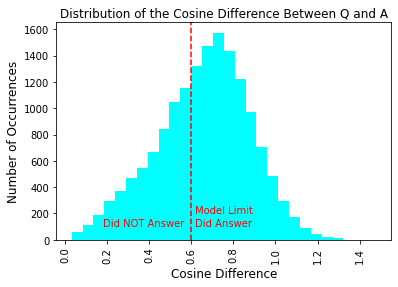

In [58]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values
limit = 0.6
# Limit determined from best practice of other comparisons

plt.hist(amazon['cosine_dist'],bins=28, color='cyan')
plt.axvline(x=limit, ls='--', c='r')
plt.annotate('Model Limit', xy=(0.62, 200), c='r')
plt.annotate('Did NOT Answer', xy=(0.18, 100), c='r')
plt.annotate('Did Answer', xy=(0.62, 100), c='r')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Cosine Difference', fontsize=12)
plt.xticks(rotation=90)
plt.title('Distribution of the Cosine Difference Between Q and A')
plt.show();

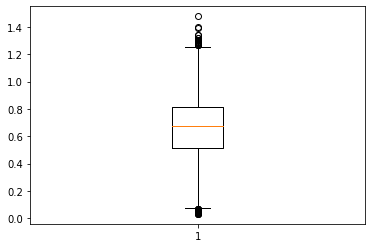

In [59]:
# As shown in the statistics for the cosine values
# The average difference between the Q and A vectors is 0.65 with std of 0.22
plt.boxplot(amazon['cosine_dist'])
plt.show()

In [60]:
# How many questions receive answers below limit?
wrong_answer_count = amazon['cosine_dist'][abs(amazon['cosine_dist'])<limit].count()
right_answer_count = amazon['cosine_dist'][abs(amazon['cosine_dist'])>=limit].count()
# Print percentage of potential wrong answers
print("If correctness of answer is based on cosine distance limit: ", limit)
print("Potential wrong answer count: ",wrong_answer_count)
print("Potential right answer count: ",right_answer_count)
print("Potential wrong answer percentage: ",100*wrong_answer_count/(wrong_answer_count+right_answer_count))

If correctness of answer is based on cosine distance limit:  0.6
Potential wrong answer count:  5740
Potential right answer count:  9831
Potential wrong answer percentage:  36.86339991008927


In [61]:
# What were the theme of the questions that were not answered?
not_answered_questions = amazon[amazon['cosine_dist']<limit]
not_answered_questions.sort_values(by=['cosine_dist'], inplace=True, ascending=False)
print("Worst Cosine Differences",not_answered_questions[['cosine_dist']][:20])
print("\nTop Unanswered Questions",not_answered_questions[['orig_question']][:20])
print("\nAnswers to Top Unanswered Questions",not_answered_questions[['orig_answer']][:20])

Worst Cosine Differences        cosine_dist
4357      0.599995
10779     0.599981
13107     0.599973
9481      0.599930
12100     0.599897
3717      0.599883
4909      0.599835
4237      0.599815
1267      0.599795
13742     0.599720
8588      0.599695
12305     0.599564
11473     0.599453
18630     0.599445
3456      0.599440
15681     0.599414
4091      0.599319
3277      0.599236
18254     0.599163
4065      0.599130

Top Unanswered Questions                                            orig_question
4357   Can someone please give me the ingredients on ...
10779  I don't see any indication of what 'roast' thi...
13107               What is the expiration date, please?
9481                where are able to deliver to, world?
12100  How is it in grinders? And is it really 26 oun...
3717                    Can you use this in a air popper
4909   Can I mix this in Buttercream frosting to pipe...
4237   How do i use this product to make pancakes? Wh...
1267           Are the coins all the 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We can see that the model does not account for answers that vary by only 1 or 2 words
For example: When the answer repeats the question and adds YES or NO to the line
    These should be shown as correct answers
To account for this combine the lowest Levenshtein distance to the model

In [62]:
# How does the cosine difference look at the product level
# group by product id (asin)
## Create product dataframe grouped by product bringing multiple questions and answers together
product_df = amazon[['asin','cosine_dist']]
product_df = product_df.groupby('asin')['cosine_dist'].mean()
print(product_df.shape)

#product_df.rename(columns={'': 'cosine_dist'},inplace=True)
print("\nProduct Data Grouped: \n",product_df.head())
print("\nGrouped Cosine Distances described: \n",product_df.describe())

(3004,)

Product Data Grouped: 
 asin
9742356831    0.663294
B00004S1C5    0.752727
B0000CD03D    0.439532
B0000CD06J    0.615516
B0000CERE4    0.500296
Name: cosine_dist, dtype: float64

Grouped Cosine Distances described: 
 count    3004.000000
mean        0.660037
std         0.126286
min         0.035460
25%         0.592728
50%         0.669033
75%         0.741748
max         1.184954
Name: cosine_dist, dtype: float64


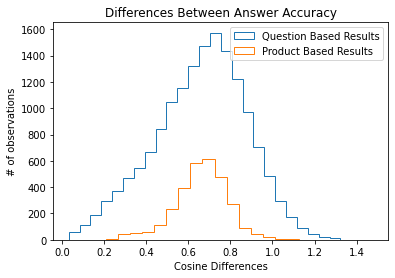

In [63]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values

fig, ax = plt.subplots()
# Plot a histogram of "Cosine Differences Question and Product Level" 
ax.hist(amazon['cosine_dist'],label='Question Based Results',bins=28,histtype='step')
ax.hist(product_df,label='Product Based Results',bins=20,histtype='step')
ax.set_xlabel("Cosine Differences")
ax.set_ylabel("# of observations")
ax.set_title("Differences Between Answer Accuracy")
# Add the legend and show the Figure
ax.legend()

The Cosine Difference did not yield strong results.  Comparing the grouped by product label (asin field in Amazon) did not yield any statistical differences in the results.  From this view, the Cosine Difference does not help predict answer accuracy as expected

# Levenshtein Distance between quesions and answers

In [64]:
# Determine Levenshtein di)stance between vectors
# The Levenshtein distance is a number that tells you how different two strings are. 
# The higher the number, the more different the two strings are.

In [65]:
# Import pylev for levenshtein method to determine a value based on two string sequences
import pylev
amazon['levenshtein_dist'] = [pylev.levenshtein(question_words_all_reduced[row],answer_words_all_reduced[row]) 
                       for row,element in enumerate(question_words_all_reduced)]
print('Levenshtein Distant Values: \n',amazon['levenshtein_dist'].describe())

Levenshtein Distant Values: 
 count    15571.000000
mean        15.150600
std         18.264013
min          0.000000
25%          6.000000
50%         10.000000
75%         17.000000
max        604.000000
Name: levenshtein_dist, dtype: float64


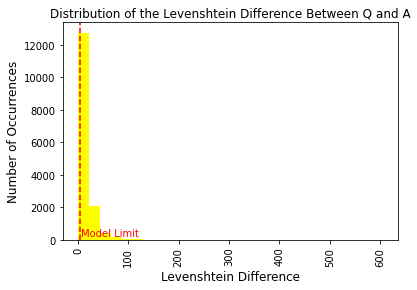

In [66]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values
plt.hist(amazon['levenshtein_dist'],bins=28, color='yellow')
plt.axvline(x=5, ls='--', c='r')
plt.annotate('Model Limit', xy=(5.5, 200), c='r')
#plt.annotate('Did NOT Answer', xy=(0.18, 100), c='r')
#plt.annotate('Did Answer', xy=(0.62, 100), c='r')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Levenshtein Difference', fontsize=12)
plt.xticks(rotation=90)
plt.title('Distribution of the Levenshtein Difference Between Q and A')
plt.show();

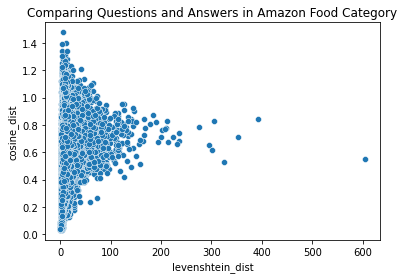

In [67]:
# Compare Cosine results to Levenshtein
sns.scatterplot(x='levenshtein_dist',y='cosine_dist', data=amazon)
plt.title('Comparing Questions and Answers in Amazon Food Category')
plt.show()


The comparison between Leveshtein and Cosine does not show a relationship.  There were equal numbers of Levenshtein values that were below 5 that had high Cosine Distance and low Cosine Distance.  The Levenshtein instead had more to say with how long the answers were instead of alignment.

# Compare Cosine & Levenshtein Values

In [68]:
# Plot CDF with data and limit line
def plot_cdf(df,data,limit,step):   
    indices = np.arange(0,1+step,step)
    fig, ax = plt.subplots() 
    cdf = pd.DataFrame({'dummy':df[data]})['dummy'].quantile(indices)
    ax.plot(cdf,indices,linewidth=3, label=data, color='blue')
    ax.set_xlabel(data)
    ax.axvline(x=limit, ls='--', c='r')
    ax.annotate('Model Limit', xy=(limit+0.05, 0.1), c='r')
    ax.set_ylabel("Percentage of observations")
    ax.set_title("CDF Differences of "+data)
    ax.legend()

In [69]:
# Determine correct counts
def count_correct(df,data,limit,step,above):
    # determine right and wrong count
    if above:
        wrong = df[data][abs(df[data]) < limit].count()
        right = df[data][abs(df[data]) >= limit].count()
    else:
        wrong = df[data][abs(df[data]) > limit].count()
        right = df[data][abs(df[data]) <= limit].count()
    percent_right = right/(wrong+right)
    # Print percentage of potential wrong answers
    print("Based on limit: ", limit)
    print("Potential wrong answer count: ",wrong)
    print("Potential right answer count: ",right)
    print("Potential right answer percentage: ",100*percent_right)

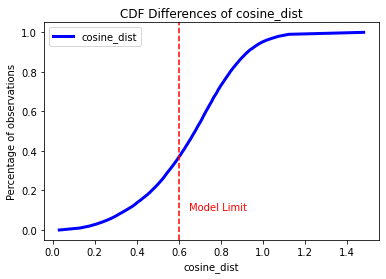

In [70]:
# Plot cdf of cosine
# Set limits
cos_limit = 0.6
plot_cdf(amazon,'cosine_dist',cos_limit,0.01)

In [71]:
# Show correct counts
count_correct(amazon,'cosine_dist',cos_limit,0.01,True)

Based on limit:  0.6
Potential wrong answer count:  5740
Potential right answer count:  9831
Potential right answer percentage:  63.13660008991073


After manual inspection of Q & A lines sorted by Levenshtein values, it was determined that the best fit line for prediction of answers matching questions was for **Values at or below 50**

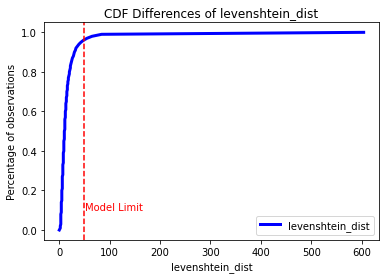

In [72]:
# Plot cdf of levenshtein
# Set limits
lev_limit = 50
plot_cdf(amazon,'levenshtein_dist',lev_limit,0.01)

In [73]:
# Show correct counts
count_correct(amazon,'levenshtein_dist',lev_limit,0.01,False)

Based on limit:  50
Potential wrong answer count:  572
Potential right answer count:  14999
Potential right answer percentage:  96.32650439920366


**Using the limit of Levenshtein at or below 50 predicts that %96.3 of all questions are answered**

In [74]:
cos_right = amazon[abs(amazon['cosine_dist']) > cos_limit]

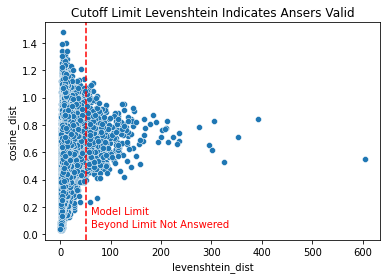

In [75]:
# Compare Cosine results to Levenshtein
sns.scatterplot(x='levenshtein_dist',y='cosine_dist', data=amazon)
plt.axvline(x=lev_limit, ls='--', c='r')
plt.annotate('Model Limit', xy=(limit+60, 0.15), c='r')
plt.annotate('Beyond Limit Not Answered', xy=(limit+60, 0.05), c='r')

plt.title('Cutoff Limit Levenshtein Indicates Ansers Valid')
plt.show()

Levenshtein chosen as better predictor for answers addressing questions

In [76]:
# Add feature to data to capture assumption of valid answer
# The Levenshtein value is at or below 50 words 
# set column to show 'did_answer_q' to be 1 for yes and 0 for no
amazon['did_answer_q'] = amazon.apply(lambda x: x['levenshtein_dist']<=lev_limit, axis=1)
print("Count of did and did not answer question: \n",amazon['did_answer_q'].value_counts())
wrong = amazon['levenshtein_dist'][abs(amazon['levenshtein_dist']) > lev_limit]
right = amazon['levenshtein_dist'][abs(amazon['levenshtein_dist']) <= lev_limit]
print("Did Answer Count: ",right.count(),"     Did Not Answer Count: ",wrong.count())
print("percentage Questions that were answered: ",right.count()/(right.count()+wrong.count())*100)

Count of did and did not answer question: 
 True     14999
False      572
Name: did_answer_q, dtype: int64
Did Answer Count:  14999      Did Not Answer Count:  572
percentage Questions that were answered:  96.32650439920366


In [77]:
amazon.describe()

,cosine_dist,levenshtein_dist
count,15571.000000,15571.000000
mean,0.657847,15.150600
std,0.220404,18.264013
min,0.032091,0.000000
25%,0.515873,6.000000
50%,0.677209,10.000000
75%,0.811843,17.000000
max,1.477766,604.000000


# Save results to csv file

In [78]:
# Save samples results to csv file for offline review
data_results = r'Capstone_Dataset/Amazon_Food_Analysis.csv'
amazon.to_csv(data_results)

# Plot the words found using PCA to reduce dimensions

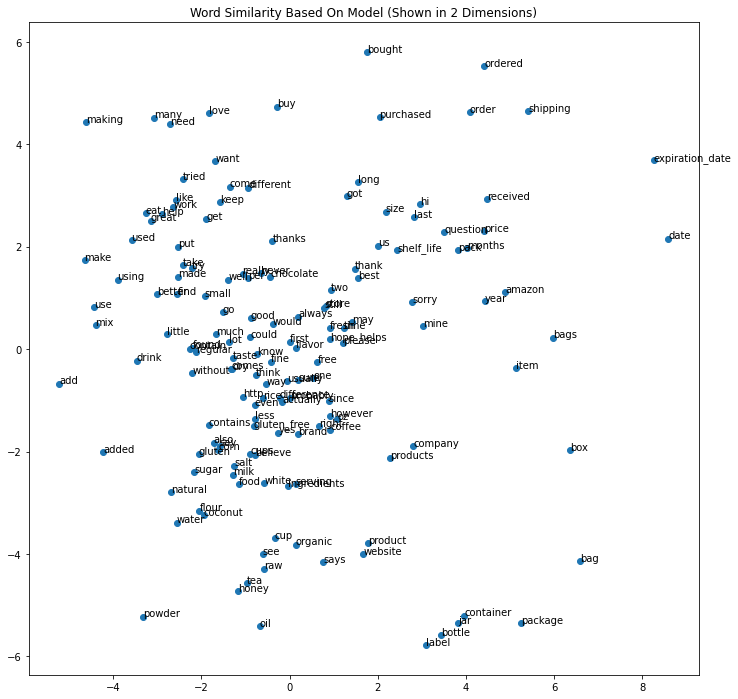

In [79]:
# Apply PCA to reduce dimensionality and list sample of 150 words
model_vectors = d2v_model[d2v_model.wv.key_to_index]
pca = PCA(n_components=2)

# Look at a sampling
result = pca.fit_transform(model_vectors[:150])

# Plot scatter of words
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(12)
ax.scatter(result[:,0],result[:,1])
plt.title("Word Similarity Based On Model (Shown in 2 Dimensions)")
words = list(d2v_model.wv.key_to_index)
for i, word in enumerate(words[:150]):
   ax.annotate(word, xy=(result[i, 0], result[i, 1]))

# Review results of model predictions of correct answers

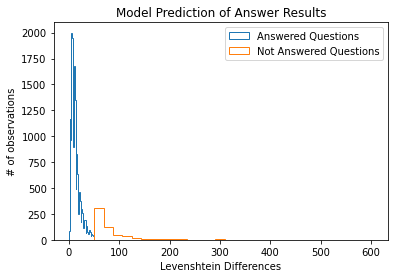

In [80]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values

fig, ax = plt.subplots()
# Plot a histogram of "Cosine Differences Question and Product Level" 
ax.hist(right,label='Answered Questions',bins=30,histtype='step')
ax.hist(wrong,label='Not Answered Questions',bins=30,histtype='step')
ax.set_xlabel("Levenshtein Differences")
ax.set_ylabel("# of observations")
ax.set_title("Model Prediction of Answer Results")
# Add the legend and show the Figure
ax.legend()

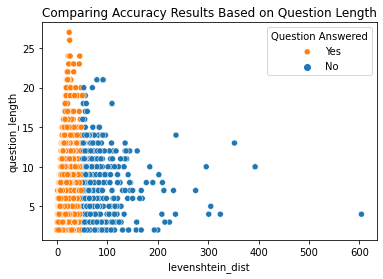

In [81]:
# Compare Levenshtein to Answer Length for Answered and Unanswered Questions
amazon['question_length'] = amazon['question'].str.len()
amazon['answer_length'] = amazon['answer'].str.len()
sns.scatterplot(y='question_length',x='levenshtein_dist', hue='did_answer_q', y_jitter = True, data=amazon)
plt.title('Comparing Accuracy Results Based on Question Length')
plt.legend(title='Question Answered', labels=['Yes','No'])
plt.show()

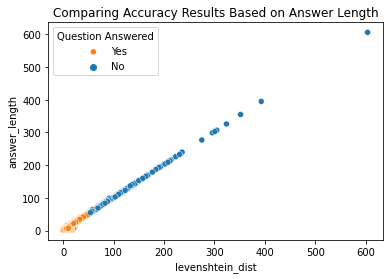

In [82]:
# Compare Levenshtein to Answer Length for Answered and Unanswered Questions
sns.scatterplot(y='answer_length',x='levenshtein_dist', hue='did_answer_q', y_jitter = True, data=amazon)
plt.title('Comparing Accuracy Results Based on Answer Length')
plt.legend(title='Question Answered', labels=['Yes','No'])
plt.show()

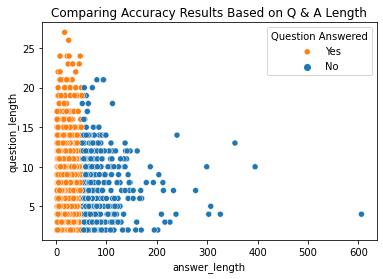

In [83]:
# Compare results between Question and Answer Length for Answered and Unanswered Questions
sns.scatterplot(x='answer_length',y='question_length', hue='did_answer_q', y_jitter = True, data=amazon)
plt.title('Comparing Accuracy Results Based on Q & A Length')
plt.legend(title='Question Answered', labels=['Yes','No'])
plt.show()

# Compare model results to new test data

In [84]:
# A sampling of Amazon Gourmet Foods product Q and A data was aquired on Sept 26-28, 2021.
# Data was manually copied from Amazon website, randomly searched for products in all
# sub categories of Gourmet Food category

# Define path for Amazon data
sample_path = r'Capstone_Dataset/Amazon_Food_Q_A_Post_2019_Sample.xlsx'
samples = pd.read_excel(sample_path)
print('Shape of the data: ',samples.shape,'\n')
samples.head()

Shape of the data:  (160, 4) 



,ASIN,question,answer,date
0,B00L26YPLQ,Is this non gmo?,"Who knows and who cares, it’s by far the best ...",2021-09-08
1,B00L26YPLQ,Salt content ?,There is 120mg of sodium in the Rao's Homemade...,2021-07-19
2,B00L26YPLQ,How many ounces is this jar?,Rao's Homemade Pizza sauce jar is 13 oz.,2021-05-12
3,B00L26YPLQ,Are the onions in this visible? Or are they bl...,All of our ingredients are blended for taste i...,2020-08-24
4,B00L26YPLQ,Gluten free correct?,Our products do not contain gluten ingredients...,2021-01-28


In [85]:
# Create samples dataframe holding the product id, question, and associated answer
samples = samples[['ASIN', 'question', 'answer']]
samples[['question', 'answer']] = samples[['question', 'answer']].astype(str)
print(samples.head(),'\n')
# Find the most common words in the samples questions keeping the stopwords
samples_question_phrases = find_phrases(samples['question'])
print("samples_Question phrases count: ",len(samples_question_phrases),'\n')

         ASIN                                           question  \
0  B00L26YPLQ                                   Is this non gmo?   
1  B00L26YPLQ                                     Salt content ?   
2  B00L26YPLQ                       How many ounces is this jar?   
3  B00L26YPLQ  Are the onions in this visible? Or are they bl...   
4  B00L26YPLQ                               Gluten free correct?   

                                              answer  
0  Who knows and who cares, it’s by far the best ...  
1  There is 120mg of sodium in the Rao's Homemade...  
2           Rao's Homemade Pizza sauce jar is 13 oz.  
3  All of our ingredients are blended for taste i...  
4  Our products do not contain gluten ingredients...   

samples_Question phrases count:  160 



In [86]:
# Find the most common words in the questions removing the stopwords 
q_new_words = find_phrases(samples['question'], True)
q_new_dictionary = Dictionary(q_new_words)
print("Samples Question Dictionary:\n",q_new_dictionary)

Samples Question Dictionary:
 Dictionary(466 unique tokens: ['gmo', 'non', 'content', 'salt', 'jar']...)


In [87]:
# Find the most common words in the answers removing the stopwords 
a_new_words = find_phrases(samples['answer'], True)
a_new_dictionary = Dictionary(a_new_words)
print("Samples Answer Dictionary:\n",a_new_dictionary)

Samples Answer Dictionary:
 Dictionary(1098 unique tokens: ['best', 'cares', 'eat', 'enjoy', 'ever']...)


In [88]:
# Update list for all cleaned words per product question
q_new_words_all = []
[q_new_words_all.append([x]) for x in q_new_words]
print("New Samples Question Length: ",len(q_new_words_all))

# Update list for all cleaned answer words
a_new_words_all = []
[a_new_words_all.append([x]) for x in a_new_words]
print("New Samples Answer Length: ",len(a_new_words_all))

New Samples Question Length:  160
New Samples Answer Length:  160


In [89]:
# Find any Bigrams in the sample questions
q_new_bigram = Phrases(q_new_words, min_count=5, threshold=10)
print("Top sample question bigrams found:\n")
q_new_bigram_list = []
for phrase, score in q_new_bigram.find_phrases(q_new_words).items():
    q_new_bigram_list.append([score,phrase])
q_new_bigram_list.sort(reverse=True)
pprint(q_new_bigram_list[0:20])

Top sample question bigrams found:

[[17.785714285714285, 'gluten_free']]


In [90]:
# Find the Bigrams in the sample answers
a_new_bigram = Phrases(a_new_words, min_count=5, threshold=10)
print("Top sample answer bigrams found:\n")
a_new_bigram_list = []
for phrase, score in a_new_bigram.find_phrases(a_new_words).items():
    a_new_bigram_list.append([score,phrase])
a_new_bigram_list.sort(reverse=True)
pprint(a_new_bigram_list[0:20])

Top sample answer bigrams found:

[]


In [91]:
# Infer vectors for new questions and answers
# Questions
q_new_vectors = []
for q in q_new_words:
    q_new_vectors.append(d2v_model.infer_vector(q))
print("New Question Vectors count:   ",len(q_new_vectors))
print()

# Answers
a_new_vectors = []
for a in a_new_words:
    a_new_vectors.append(d2v_model.infer_vector(a))
print("New Question Vectors count:   ",len(a_new_vectors))

New Question Vectors count:    160

New Question Vectors count:    160


In [92]:
# Determine Levenshtein between new vectors
samples['levenshtein_dist'] = [pylev.levenshtein(q_new_words[row],a_new_words[row]) 
                       for row,element in enumerate(q_new_words)]
print("Levenshtein Distances described: \n",samples['levenshtein_dist'].describe())

Levenshtein Distances described: 
 count    160.000000
mean      13.650000
std       13.771815
min        0.000000
25%        5.000000
50%        8.500000
75%       18.000000
max       76.000000
Name: levenshtein_dist, dtype: float64


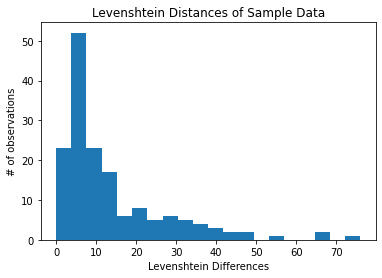

In [93]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values
fig, ax = plt.subplots()
ax.set_title("Levenshtein Distances of Sample Data")
ax.hist(samples['levenshtein_dist'],bins=20)
ax.set_xlabel("Levenshtein Differences")
ax.set_ylabel("# of observations")
plt.show()

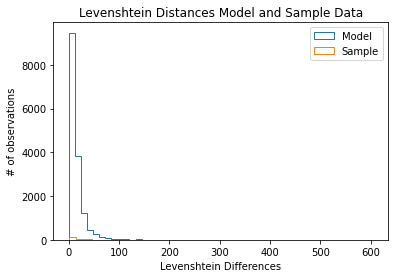

In [94]:
# Compare the distribution of the differences
# Between model and sample data

fig, ax = plt.subplots()
# Plot a histogram of "Cosine Differences Question and Product Level" 
ax.hist(amazon['levenshtein_dist'],label='Model',bins=50,histtype='step')
ax.hist(samples['levenshtein_dist'],label='Sample',bins=5,histtype='step')
ax.set_xlabel("Levenshtein Differences")
ax.set_ylabel("# of observations")
ax.set_title("Levenshtein Distances Model and Sample Data")
# Add the legend and show the Figure
ax.legend()

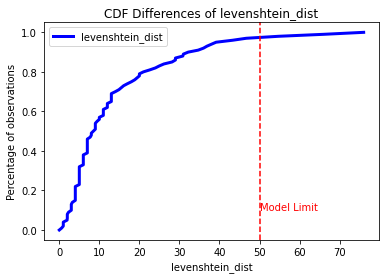

In [95]:
# Plot cdf of levenshtein
plot_cdf(samples,'levenshtein_dist',lev_limit,0.01)

In [96]:
# Show correct counts
count_correct(samples,'levenshtein_dist',lev_limit,0.01,False)

Based on limit:  50
Potential wrong answer count:  4
Potential right answer count:  156
Potential right answer percentage:  97.5


# Review the types of questions left unanswered

In [97]:
wrong_answers = amazon[abs(amazon['levenshtein_dist']) > lev_limit]
wrong_answers.head()

,asin,orig_question,orig_answer,question,question_str,answer,answer_str,cosine_dist,levenshtein_dist,did_answer_q,question_length,answer_length
30,B0000CFLCT,How many ounces does the pot hold? Is it 6 fiv...,Although I don't have the pot at my current lo...,"[many_ounces, pot, hold, five, ounce, cups, ei...",many_ounces pot hold five ounce cups eight oun...,"[although, pot, current, location, check, sure...",although pot current location check sure belie...,0.608653,56,False,19,60
38,B0000CFLCT,"The water pours through way too fast, making v...",Water pours too fast if all the grounds are st...,"[water, pours, way, fast, making, weak, coffee...",water pours way fast making weak coffee use fi...,"[water, pours, fast, grounds, stuck, side, fil...",water pours fast grounds stuck side filter pou...,0.528719,68,False,12,71
55,B0000CFMU3,Do you think this would work for securing rasp...,I'm assuming you mean to put the raspberries o...,"[think, would, work, securing, raspberries, bu...",think would work securing raspberries buttercr...,"[assuming, mean, put, raspberries, side, cake,...",assuming mean put raspberries side cake first ...,0.708291,56,False,6,56
66,B0000D9N17,"Cost over $35, why is there a shipping charge?",We ship our products via the United States Pos...,"[cost, shipping_charge]",cost shipping_charge,"[ship, products, via, united_states, postal, s...",ship products via united_states postal service...,0.660262,157,False,2,158
89,B0000DGF9V,"I have followed all watering instructions, etc...","No, it should not lose its leaves like that. b...","[followed, watering, instructions, etc, leaves...",followed watering instructions etc leaves fall...,"[lose, leaves, like, ficus, sensitive, changes...",lose leaves like ficus sensitive changes light...,0.437086,51,False,11,52


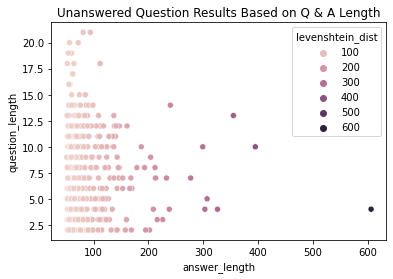

In [98]:
# Compare results between Question and Answer Length for Answered and Unanswered Questions
wrong_answers = amazon[abs(amazon['levenshtein_dist']) > lev_limit]
sns.scatterplot(x='answer_length',y='question_length', hue='levenshtein_dist', data=wrong_answers)
plt.title('Unanswered Question Results Based on Q & A Length')
plt.legend(title='levenshtein_dist')
plt.show()

From HDP model, Topic Words include: 
       value       word  topic
0  0.003933        fgo      0
1  0.003206     higher      0
2  0.003026   continue      0
3  0.002924  superfine      0
4  0.002852     robust      0


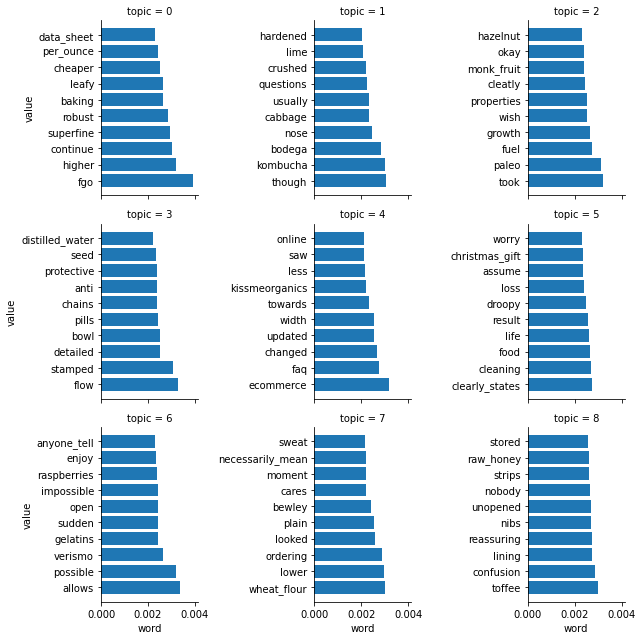

In [99]:
# Apply models from gensim for topic modeling applied to new samples

## update corpus from above with the found bigrams model
new_dict_cleaned = Dictionary(wrong_answers['question'])
new_corpus_cleaned = [new_dict_cleaned.doc2bow(word, allow_update=True) for word in a_new_words]

# Use make_hdp method to show topics for answers
make_hdp(new_corpus_cleaned,new_dict_cleaned,9)

The application of Context-free modeling using Doc2Vec from gensim on the unlabelled data from Amazon's Grocery category of Questions and Answers predicted that 96% of the questions were answered.  Of the questions

# Apply BERT method for answer prediction

BERT stands for Bidirectional Encoder Representations from Transformers. It is and NLP approach designed to pre-train from unlabeled text by jointly conditioning on both left and right context.

Bidirectional Encoder Representations from Transformers Found at: https://www.blog.google/products/search/search-language-understanding-bert/ According to the site "BERT models can therefore consider the full context of a word by looking at the words that come before and after it" Must include all stopwords when applying BERT models

Source code for Bert sourced from Alammar, Jay https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

Setup our data in a format that we can use when building our tokenizer. Create a set of plaintext, and split each sample using a newline \n

In [100]:
import torch
from sklearn.model_selection import train_test_split

In [101]:
#bert_data['question'] = bert_data['question'].astype(str)
#bert_data.groupby(level=0).agg(' '.join)
bert_data = amazon[['asin','did_answer_q']]
bert_data['question'] = [' '.join(map(str, l)) for l in amazon['question']]

'''for val in amazon['did_answer_q']:   
    bert_result.append(val)
print("\nbert_result:\n",bert_result)
bert_data = list(zip(bert_q,bert_result))'''
print("Shape of BERT data: ",bert_data.shape)
bert_data.head()

Shape of BERT data:  (15571, 3)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,asin,did_answer_q,question
0,9742356831,True,heat compared yellow_red curry
2,9742356831,True,ingredients exactly product thanks
3,9742356831,True,important expiraci oacute n date curry paste
5,9742356831,True,photo product red curry selling green_curry ge...
6,B00004S1C5,True,product come first search organic food_colorin...


In [102]:
# Load pretrained model
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [103]:
# Review predictions for questions being answerd
bert_data['did_answer_q'].value_counts()

True     14999
False      572
Name: did_answer_q, dtype: int64

In [104]:
# Preprocess data by tokenizing the questions
tokenized = bert_data['question'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [105]:
# Padding, BERT wants to process all at once, so all vectors need to be same size
# Pad by filling in vectors with zeros

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
# Show shape of pretrained model
np.array(padded).shape

(15571, 40)

In [106]:
# Create mask to have BERT ignore the padding
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(15571, 40)

In [107]:
# Set up model function
start_time = time.time()
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
print("Time to set up BERT Model: ",round(time.time()-start_time),"seconds")

Time to set up BERT Model:  1231 seconds


In [108]:
# save features variable along with labels
features = last_hidden_states[0][:,0,:].numpy()
labels = bert_data['did_answer_q']

In [109]:
# Train Test split our data
X_train, X_test, y_train, y_test = train_test_split(features, labels)

In [110]:
# Train the model
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [111]:
lr_clf.score(X_test, y_test)

0.9609555612638069